## Imports

In [ ]:
import numpy as np
import wfdb
import matplotlib.pyplot as plt
from data import Record, RecordBuilder
from signal_generator import generate_ecg
import os
import ipywidgets as widgets
from IPython.display import display, clear_output
import scipy as sp

## Code

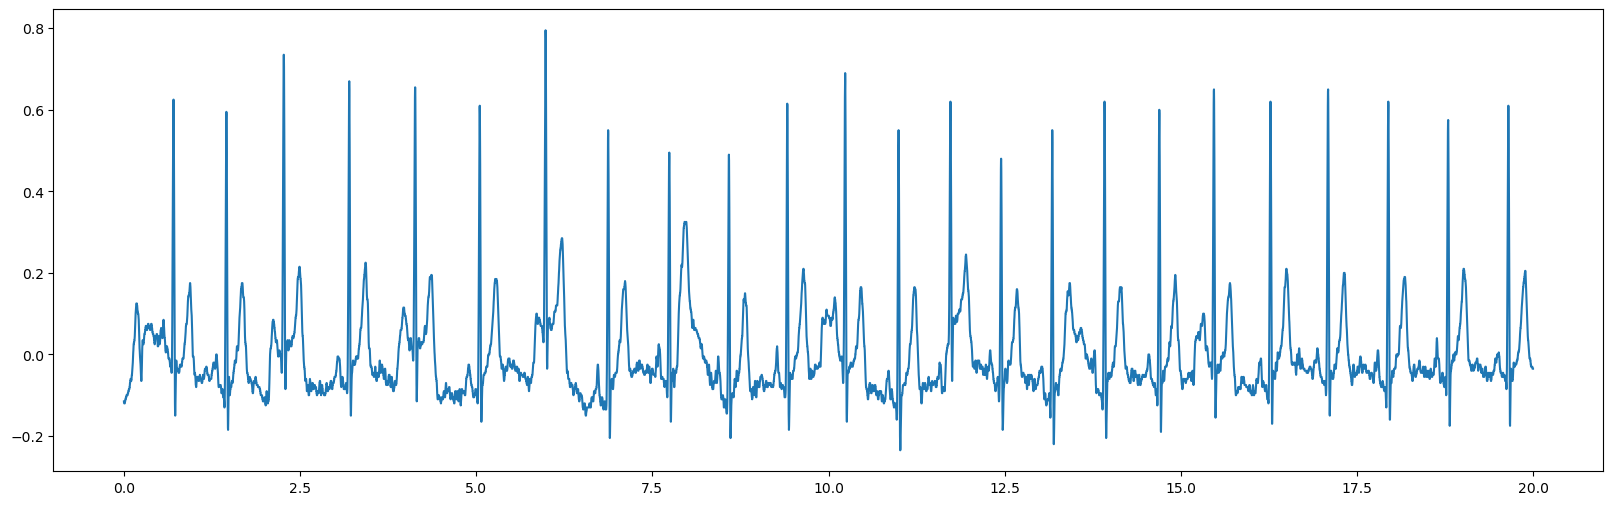

In [2]:
record = RecordBuilder.fetch_record(1, 1)
plt.figure(figsize=(20,6))
plt.plot(np.arange(record.clean_signal.shape[0]) / record.sampling_frequency, record.clean_signal)
plt.show()

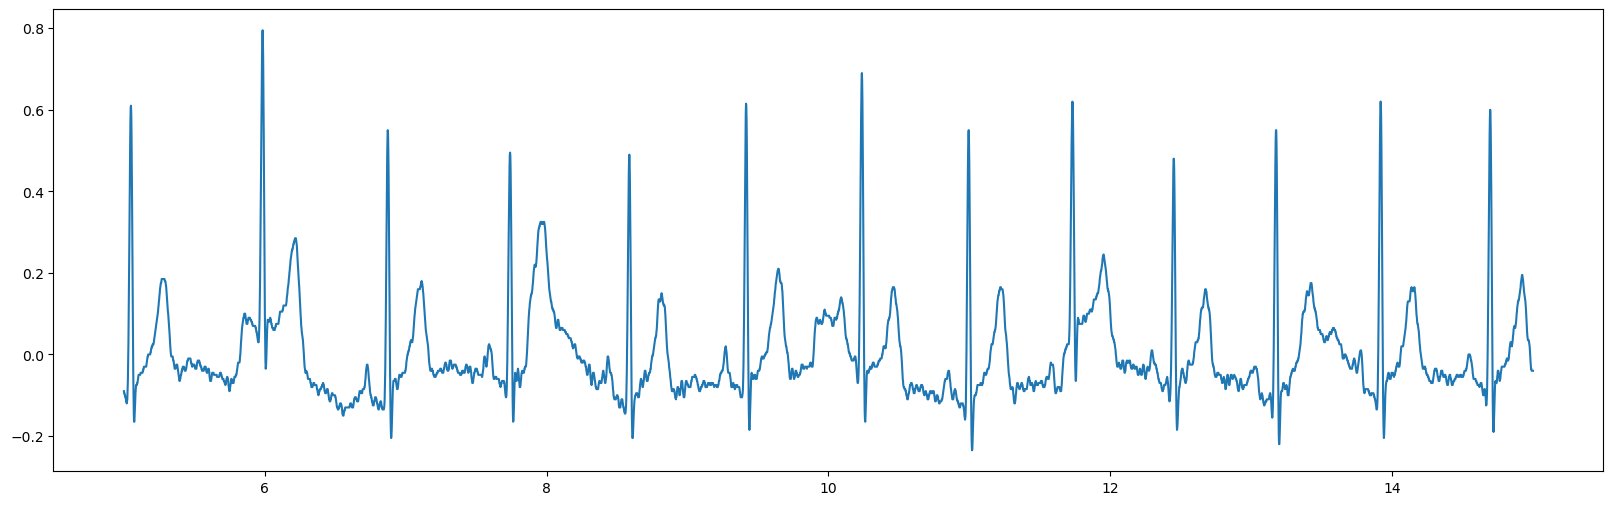

In [ ]:
times, signal = record.get_segment(5.0, 10.0)
plt.figure(figsize=(20,6))
plt.plot(times, signal)
plt.show()

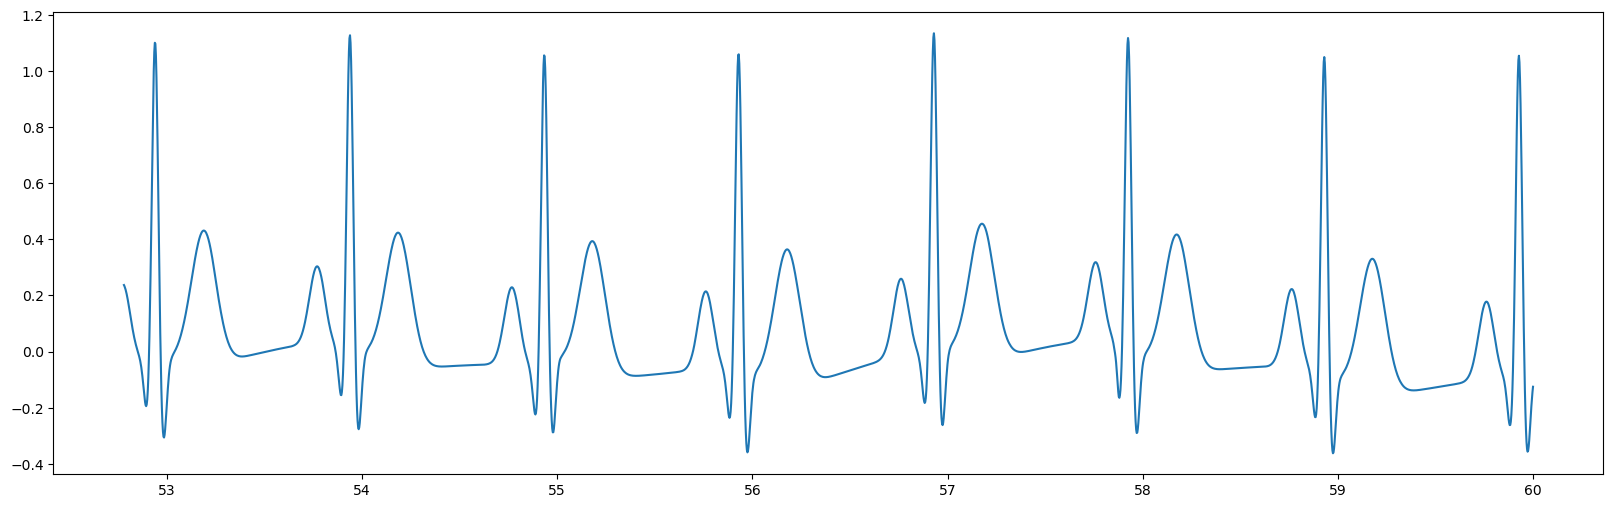

In [ ]:
times, signal = generate_ecg()
plt.figure(figsize=(20,6))
plt.plot(times[19000:], signal[19000:])
plt.show()

## Going through the signals

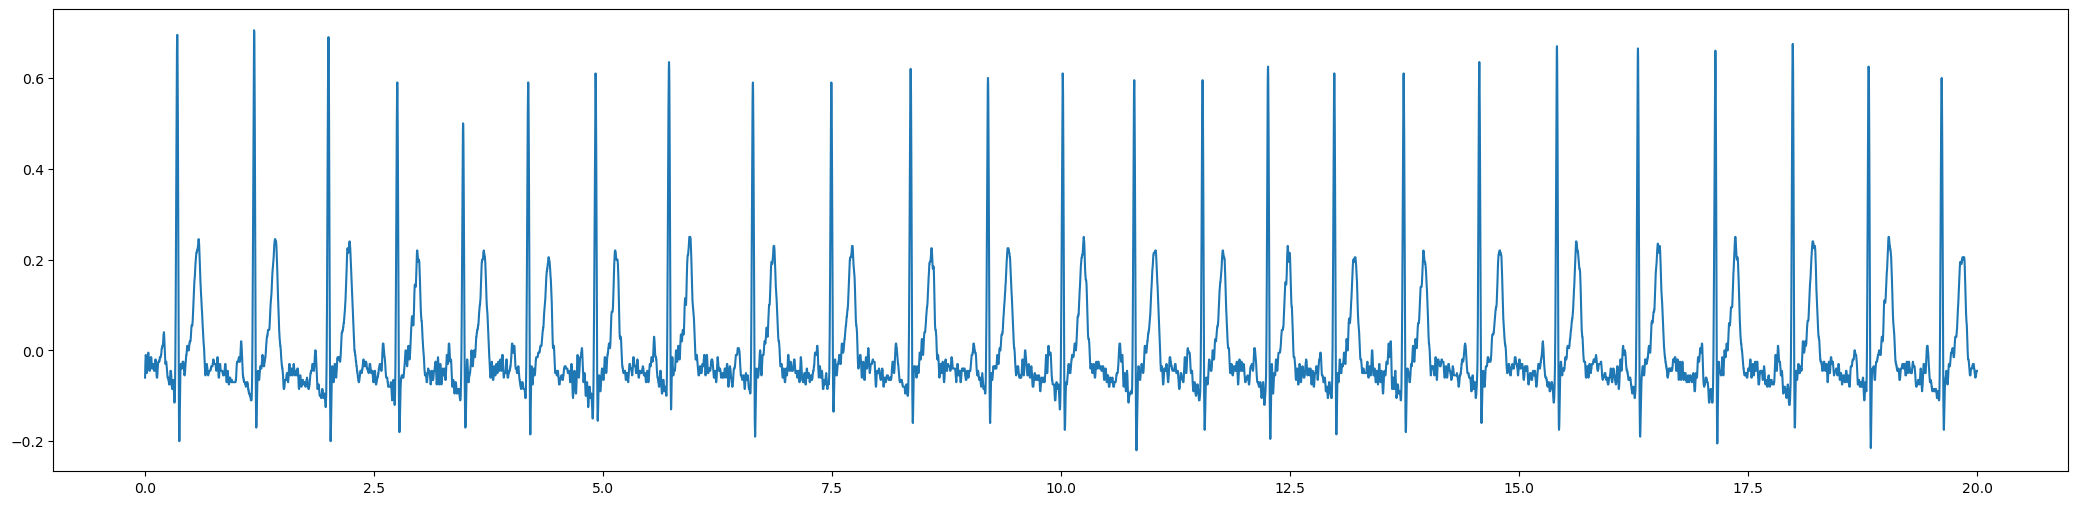

In [ ]:
record = RecordBuilder.fetch_record(1, 2)
plt.figure(figsize=(26,6))
plt.plot(np.arange(record.clean_signal.shape[0]) / record.sampling_frequency, record.clean_signal)
plt.show()

In [ ]:
fig = plt.figure(figsize=(26,8))
ax = fig.add_subplot()
plt.close(fig)

@widgets.interact(person=(1,54,1), sample=(1,20,1))
def update_plot(person: int, sample: int):
    clear_output()
    record = None
    ax.clear()
    try: 
        record = RecordBuilder.fetch_record(person, sample)
    except:
        pass
    if record is not None:
        ax.set_title(f"Sample {person}.{sample}")
        ax.plot(np.arange(record.clean_signal.shape[0]) / record.sampling_frequency, record.clean_signal)
    else:
        ax.set_title("Sample does not exist")
        ax.plot(np.arange(10), np.arange(10))
    fig.canvas.draw()
    # plt.show()
    _=display(fig)

# person_slider = widgets.IntSlider(min=1, max=54, step=1, value=1, description="Person")
# sample_slider = widgets.IntSlider(min=1, max=20, step=1, value=1, description="Sample")
# interactive = widgets.interactive(update_plot, person=person_slider, sample=sample_slider)

# clear_output()
# display(interactive)

In [ ]:
fig.canvas

## Preparing dataset

In [45]:
fig, ax = plt.subplots(figsize=(16,6))
plt.close()

def update_plot(person: int, sample: int, time: float, duration: float):
    clear_output()
    record = None
    ax.clear()
    try: 
        record = RecordBuilder.fetch_record(person, sample)
    except:
        pass
    if record is not None:
        ax.set_title(f"Sample {person}.{sample}")
        time, signal = record.get_segment(time, duration)
        ax.plot(time, signal)
    else:
        ax.set_title("Sample does not exist")
        ax.plot(np.arange(10), np.arange(10))
    # plt.show()
    # fig.canvas.draw()
    display(fig)
    return None

person_slider = widgets.IntSlider(min=1, max=54, step=1, value=1, description="Person")
sample_slider = widgets.IntSlider(min=1, max=20, step=1, value=1, description="Sample")
time_slider = widgets.FloatSlider(min=0.0, max=20.0, step=0.1, value=0.0, description="Time")
window_slider = widgets.FloatSlider(min=1.0, max=5.0, step=0.05, value=2.0, description="Duration")
interactive = widgets.interact(update_plot, person=person_slider, sample=sample_slider, time=time_slider, duration=window_slider)
_=display(interactive)

interactive(children=(IntSlider(value=1, description='Person', max=54, min=1), IntSlider(value=1, description=…

<function __main__.update_plot(person: int, sample: int, time: float, duration: float)>

In [46]:
person_value = person_slider.value
sample_value = sample_slider.value
time_value = time_slider.value
duration_value = window_slider.value
print(f"Sample:\t\t\t {person_value}-{sample_value}")
print(f"Time window:\t\t {time_value} - {time_value + duration_value}")
print("------------------------------------------------------------------")
record = RecordBuilder.fetch_record(person_value, sample_value)
time, signal = record.get_segment(time_value, duration_value)
peaks, info = sp.signal.find_peaks(signal, height=0.4)
smin = np.min(signal)
smax = np.max(signal)
smean = np.mean(signal)
print(f"Signal value range:\t ({smin}, {smax})")
print(f"Signal mean:\t\t {smean:.4f}")
print(f"Number of peaks:\t {len(peaks)}")

Sample:			 1-1
Time window:		 0.0 - 5.0
------------------------------------------------------------------
Signal value range:	 (-0.185, 0.735)
Signal mean:		 -0.0022
Number of peaks:	 5


In [47]:
fig, axs = plt.subplots(nrows = 2, figsize=(16,6))
plt.close(fig)

offset_slider = widgets.FloatSlider(min=0.0, max=60.0, step=0.05, value=0.0)
hr_slider = widgets.FloatSlider(min=30.0, max=120.0, step=0.5, value=60.0)

def update_simulation(hr: float, offset: float):
    clear_output()
    sim_times, sim_sig = generate_ecg(fs = record.sampling_frequency, heart_beat=hr, scale_low=smin, scale_high=smax)
    start = int(offset * record.sampling_frequency)
    end = min(int((offset + duration_value)*record.sampling_frequency), len(sim_sig))
    axs[0].clear()
    axs[1].clear()
    axs[0].plot(sim_times[start:end], sim_sig[start:end])
    axs[1].plot(time, signal)
    # plt.show()
    fig.canvas.draw()
    display(fig)
    return None


interactive = widgets.interact(update_simulation, hr=hr_slider, offset=offset_slider)
_ = display(interactive)

interactive(children=(FloatSlider(value=60.0, description='hr', max=120.0, min=30.0, step=0.5), FloatSlider(va…

<function __main__.update_simulation(hr: float, offset: float)>

## Crete csv

In [49]:
persons = [1,1,1,2,2,2,3,8,10,10,12,16,17,23,24,25,26]
samples = [1,4,15,3,7,20,5,2,1,5,1,1,2,1,4,5,4]

for person, sample in zip(persons, samples):
    record = RecordBuilder.fetch_record(person, sample)
    times, signal = record.get_segment(0.0, 20.0)

    peaks, _ = sp.signal.find_peaks(signal, height=0.4)

    #hbeats = len(peaks) / (times[-1] - times[0]) * 60.0 # TODO: opravit!

    rr_intervals = np.diff(peaks) / record.sampling_frequency  # rozdíly v sekundách
    mean_rr = np.mean(rr_intervals)
    hbeats = 60 / mean_rr  # bpm

    print(f"Sample {person}.{sample} - Heart rate: {hbeats:.2f} bpm")

    smin, smax = np.min(signal), np.max(signal)
    smean, sstd = np.mean(signal), np.std(signal)
    print(f"Signal value range:\t ({smin}, {smax})")
    print(f"Signal mean:\t\t {smean:.4f}")
    print(f"Signal std:\t\t {sstd:.4f}")
    peak = times[peaks[0]]

    offset = (60/hbeats) - peak
    sim_times, sim_sig = generate_ecg(fs = record.sampling_frequency, heart_beat=hbeats, scale_low=smin, scale_high=smax, scale_mean=smean, scale_std=sstd)

    start = int(offset * record.sampling_frequency)
    end = min(int((offset + record.duration)*record.sampling_frequency), len(sim_sig))
    
    signal2 = sim_sig[start:end]

    stop = 5000

    plt.figure(figsize=(20,6))
    plt.plot(times[:stop], signal[:stop], label="Original")
    plt.plot(times[:stop], signal2[:stop], label="Simulated")
    plt.title(f"Sample {person}.{sample}")
    plt.legend()
    plt.show()

Sample 1.1 - Heart rate: 72.85 bpm
Signal value range:	 (-0.235, 0.795)
Signal mean:		 0.0010
Signal std:		 0.1164


TypeError: generate_ecg() got an unexpected keyword argument 'scale_mean'